# 03. Feature Extraction

This notebook implements all feature extraction methods from README.md:
1. **GLCM Features** (60D): Contrast, correlation, energy, homogeneity, entropy
2. **Fractal Dimension** (1D): Box-counting method
3. **Vein Geometry** (10D): Density, length, branch points, orientation
4. **CNN Features** (1280D): MobileNetV2 embeddings using PyTorch

**Total**: 1,351-dimensional feature vector per image

**Author**: Kuan-Chen, Chen  
**Hardware**: CUDA-enabled GPU

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pickle

from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import skeletonize
from scipy import ndimage

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

np.random.seed(42)
torch.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8


## 2. Feature Extraction Parameters (from README.md)

In [2]:
# GLCM parameters
GLCM_DISTANCES = [1, 3, 5]                      # Multi-scale analysis
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0°, 45°, 90°, 135°
GLCM_LEVELS = 256                               # Grayscale levels
GLCM_SYMMETRIC = True
GLCM_NORMED = True

# Fractal dimension parameters
FRACTAL_MIN_BOX = 2
FRACTAL_MAX_BOX = 128
FRACTAL_NUM_SCALES = 20

# Vein analysis parameters
CLAHE_CLIP_LIMIT = 2.0
CLAHE_GRID_SIZE = (8, 8)
CANNY_THRESHOLD1 = 50
CANNY_THRESHOLD2 = 150
CANNY_APERTURE = 3

# CNN parameters
CNN_INPUT_SIZE = (224, 224)
CNN_BATCH_SIZE = 32
CNN_FEATURE_DIM = 1280  # MobileNetV2 output

print("Feature Extraction Parameters:")
print(f"  GLCM: {len(GLCM_DISTANCES)} distances × {len(GLCM_ANGLES)} angles = {len(GLCM_DISTANCES)*len(GLCM_ANGLES)} matrices")
print(f"  Fractal: {FRACTAL_NUM_SCALES} scales from {FRACTAL_MIN_BOX} to {FRACTAL_MAX_BOX}")
print(f"  CNN: MobileNetV2 → {CNN_FEATURE_DIM}D embeddings")
print(f"  Total features: 60 (GLCM) + 1 (Fractal) + ~10 (Vein) + {CNN_FEATURE_DIM} (CNN) = ~1351D")

Feature Extraction Parameters:
  GLCM: 3 distances × 4 angles = 12 matrices
  Fractal: 20 scales from 2 to 128
  CNN: MobileNetV2 → 1280D embeddings
  Total features: 60 (GLCM) + 1 (Fractal) + ~10 (Vein) + 1280 (CNN) = ~1351D


## 3. GLCM Feature Extraction

In [3]:
def extract_glcm_features(image_gray):
    """
    Extract GLCM texture features.
    
    Features extracted:
    - Contrast: (i-j)^2 * P(i,j) - roughness proxy
    - Correlation: Linear dependency - anisotropy measure
    - Energy: Sum of squared elements - uniformity
    - Homogeneity: Closeness to diagonal - inverse roughness
    - ASM (Angular Second Moment): Energy squared
    
    Args:
        image_gray: Grayscale image (0-255)
    
    Returns:
        features: 60D feature vector
    """
    # Compute GLCM
    glcm = graycomatrix(
        image_gray,
        distances=GLCM_DISTANCES,
        angles=GLCM_ANGLES,
        levels=GLCM_LEVELS,
        symmetric=GLCM_SYMMETRIC,
        normed=GLCM_NORMED
    )
    
    # Extract properties
    features = []
    
    # 5 metrics × 4 angles × 3 distances = 60 features
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'ASM']:
        prop_values = graycoprops(glcm, prop).flatten()
        features.extend(prop_values)
    
    return np.array(features)


# Test on sample image
BASE_DIR = Path('..').resolve()
TRAIN_DIR = BASE_DIR / 'tomato' / 'train'

sample_img_path = list((TRAIN_DIR / 'Tomato___healthy').glob('*.jpg'))[0]
sample_img = cv2.imread(str(sample_img_path), cv2.IMREAD_GRAYSCALE)
sample_img = cv2.resize(sample_img, CNN_INPUT_SIZE)

glcm_features = extract_glcm_features(sample_img)
print(f"\n✓ GLCM features extracted: {len(glcm_features)}D")
print(f"  Feature range: [{glcm_features.min():.4f}, {glcm_features.max():.4f}]")
print(f"  Mean: {glcm_features.mean():.4f}, Std: {glcm_features.std():.4f}")


✓ GLCM features extracted: 60D
  Feature range: [0.0004, 232.4730]
  Mean: 38.1656, Std: 77.2670


## 4. Fractal Dimension (Box-Counting)

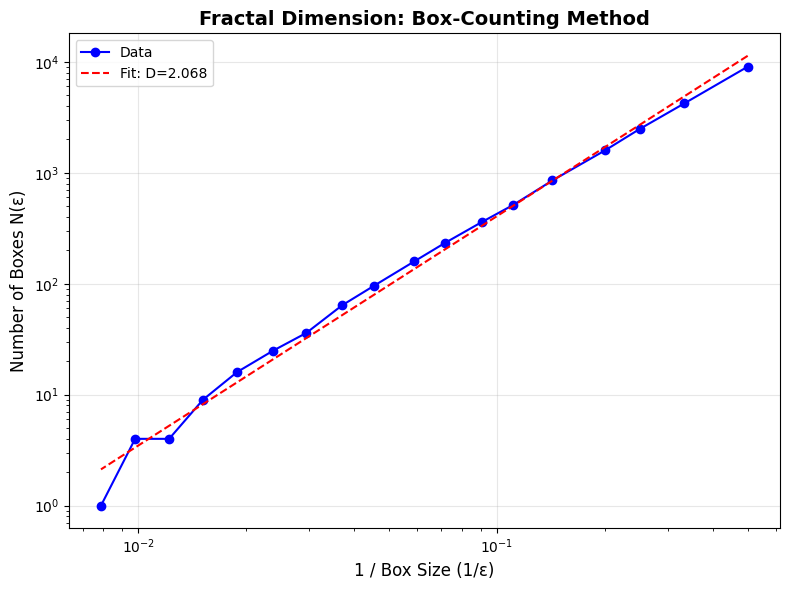


✓ Fractal dimension: 2.0677
  Interpretation: 1.0 (smooth) < 2.068 < 2.0 (space-filling)


In [4]:
def compute_fractal_dimension(image_gray, show_plot=False):
    """
    Compute fractal dimension using box-counting method.
    
    Algorithm:
    1. Convert to binary (threshold or edge detection)
    2. For each box size ε, count boxes needed to cover pattern
    3. Plot log(N(ε)) vs log(1/ε)
    4. Fractal dimension = slope of linear fit
    
    Args:
        image_gray: Grayscale image
        show_plot: If True, plot log-log relationship
    
    Returns:
        fractal_dim: Fractal dimension (float)
    """
    # Convert to binary (threshold at mean)
    threshold = image_gray.mean()
    binary = (image_gray > threshold).astype(np.uint8)
    
    # Box sizes (geometric progression)
    box_sizes = np.logspace(
        np.log10(FRACTAL_MIN_BOX),
        np.log10(FRACTAL_MAX_BOX),
        FRACTAL_NUM_SCALES,
        dtype=int
    )
    box_sizes = np.unique(box_sizes)  # Remove duplicates
    
    counts = []
    
    for box_size in box_sizes:
        # Downsample by max pooling
        h, w = binary.shape
        h_boxes = h // box_size
        w_boxes = w // box_size
        
        if h_boxes == 0 or w_boxes == 0:
            continue
        
        # Count non-empty boxes
        count = 0
        for i in range(h_boxes):
            for j in range(w_boxes):
                box = binary[i*box_size:(i+1)*box_size, j*box_size:(j+1)*box_size]
                if box.sum() > 0:
                    count += 1
        
        counts.append(count)
    
    # Convert to arrays
    box_sizes = np.array(box_sizes[:len(counts)])
    counts = np.array(counts)
    
    # Linear fit in log-log space
    coeffs = np.polyfit(np.log(1/box_sizes), np.log(counts), 1)
    fractal_dim = coeffs[0]
    
    if show_plot:
        plt.figure(figsize=(8, 6))
        plt.loglog(1/box_sizes, counts, 'bo-', label='Data')
        plt.loglog(1/box_sizes, np.exp(coeffs[1]) * (1/box_sizes)**fractal_dim, 'r--', 
                   label=f'Fit: D={fractal_dim:.3f}')
        plt.xlabel('1 / Box Size (1/ε)', fontsize=12)
        plt.ylabel('Number of Boxes N(ε)', fontsize=12)
        plt.title('Fractal Dimension: Box-Counting Method', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return fractal_dim


# Test fractal dimension
fractal_dim = compute_fractal_dimension(sample_img, show_plot=True)
print(f"\n✓ Fractal dimension: {fractal_dim:.4f}")
print(f"  Interpretation: 1.0 (smooth) < {fractal_dim:.3f} < 2.0 (space-filling)")

## 5. Vein Geometry Analysis

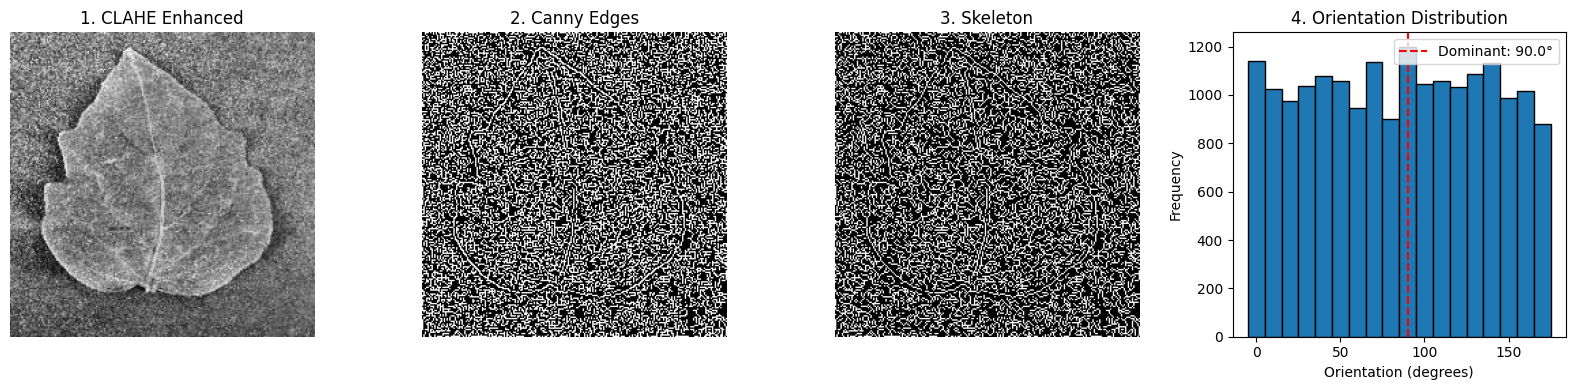


✓ Vein features extracted: 10D
  Vein density: 0.3117
  Branch points: 5553
  Dominant orientation: 90.0°


In [5]:
def extract_vein_features(image_gray, show_steps=False):
    """
    Extract vein geometry features.
    
    Pipeline:
    1. CLAHE enhancement
    2. Canny edge detection
    3. Morphological skeletonization
    4. Compute geometry metrics
    
    Features:
    - Vein density (total skeleton pixels / total pixels)
    - Total vein length (skeleton pixel count)
    - Branch points (pixels with >2 neighbors)
    - Endpoint count
    - Dominant orientation (mode of edge angles)
    - Orientation variance
    - Mean/std vein thickness
    
    Returns:
        features: 10D vein feature vector
    """
    # Step 1: CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_GRID_SIZE)
    enhanced = clahe.apply(image_gray)
    
    # Step 2: Canny edge detection
    edges = cv2.Canny(enhanced, CANNY_THRESHOLD1, CANNY_THRESHOLD2, apertureSize=CANNY_APERTURE)
    
    # Step 3: Skeletonization
    skeleton = skeletonize(edges // 255).astype(np.uint8)
    
    # Total pixels
    total_pixels = skeleton.shape[0] * skeleton.shape[1]
    
    # Feature 1-2: Vein density and length
    vein_pixels = skeleton.sum()
    vein_density = vein_pixels / total_pixels
    
    # Feature 3-4: Branch points and endpoints
    # Count neighbors for each pixel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbor_count = ndimage.convolve(skeleton.astype(float), kernel, mode='constant')
    neighbor_count = neighbor_count * skeleton  # Only count on skeleton
    
    branch_points = (neighbor_count > 2).sum()
    endpoints = (neighbor_count == 1).sum()
    
    # Feature 5-6: Orientation analysis
    # Compute gradients
    sobel_x = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
    angles = np.arctan2(sobel_y, sobel_x)  # Range: [-π, π]
    
    # Only consider angles on edges
    edge_angles = angles[edges > 0]
    
    if len(edge_angles) > 0:
        # Convert to 0-180 degrees
        edge_angles_deg = np.abs(np.rad2deg(edge_angles)) % 180
        
        # Dominant orientation (histogram peak)
        hist, bins = np.histogram(edge_angles_deg, bins=18, range=(0, 180))
        dominant_orientation = bins[hist.argmax()]
        
        # Orientation variance (circular variance)
        orientation_variance = np.var(edge_angles_deg)
    else:
        dominant_orientation = 0
        orientation_variance = 0
    
    # Feature 7-10: Additional metrics
    avg_neighbors = neighbor_count[skeleton > 0].mean() if vein_pixels > 0 else 0
    complexity = branch_points / (vein_pixels + 1)  # Branching complexity
    
    # Assemble feature vector
    features = np.array([
        vein_density,
        vein_pixels / 1000,  # Normalized length
        branch_points,
        endpoints,
        dominant_orientation,
        orientation_variance,
        avg_neighbors,
        complexity,
        hist.max() / hist.sum(),  # Orientation concentration
        (edges > 0).sum() / total_pixels  # Edge density
    ])
    
    if show_steps:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(enhanced, cmap='gray')
        axes[0].set_title('1. CLAHE Enhanced')
        axes[0].axis('off')
        
        axes[1].imshow(edges, cmap='gray')
        axes[1].set_title('2. Canny Edges')
        axes[1].axis('off')
        
        axes[2].imshow(skeleton, cmap='gray')
        axes[2].set_title('3. Skeleton')
        axes[2].axis('off')
        
        # Orientation histogram
        axes[3].bar(bins[:-1], hist, width=10, edgecolor='black')
        axes[3].set_xlabel('Orientation (degrees)')
        axes[3].set_ylabel('Frequency')
        axes[3].set_title('4. Orientation Distribution')
        axes[3].axvline(dominant_orientation, color='r', linestyle='--', label=f'Dominant: {dominant_orientation:.1f}°')
        axes[3].legend()
        
        plt.tight_layout()
        plt.show()
    
    return features


# Test vein features
vein_features = extract_vein_features(sample_img, show_steps=True)
print(f"\n✓ Vein features extracted: {len(vein_features)}D")
print(f"  Vein density: {vein_features[0]:.4f}")
print(f"  Branch points: {vein_features[2]:.0f}")
print(f"  Dominant orientation: {vein_features[4]:.1f}°")

## 6. CNN Feature Extraction (MobileNetV2 + PyTorch)

In [6]:
class MobileNetV2FeatureExtractor(nn.Module):
    """
    MobileNetV2 feature extractor using PyTorch.
    
    Output: 1280D feature vector (global average pooling)
    """
    def __init__(self, pretrained=True):
        super().__init__()
        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=pretrained)
        
        # Remove classifier (keep features only)
        self.features = mobilenet.features
        self.pooling = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        return x


# Initialize model
print("Loading MobileNetV2 (pretrained on ImageNet)...")
cnn_model = MobileNetV2FeatureExtractor(pretrained=True)
cnn_model = cnn_model.to(device)
cnn_model.eval()
print(f"✓ Model loaded on {device}")

# Image preprocessing for CNN
cnn_transform = transforms.Compose([
    transforms.Resize(CNN_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def extract_cnn_features(image_path):
    """
    Extract CNN features from single image.
    
    Args:
        image_path: Path to RGB image
    
    Returns:
        features: 1280D feature vector
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = cnn_transform(image).unsqueeze(0).to(device)
    
    # Extract features
    with torch.no_grad():
        features = cnn_model(image_tensor)
    
    return features.cpu().numpy().flatten()


# Test CNN features
cnn_features = extract_cnn_features(sample_img_path)
print(f"\n✓ CNN features extracted: {len(cnn_features)}D")
print(f"  Feature range: [{cnn_features.min():.4f}, {cnn_features.max():.4f}]")
print(f"  Mean: {cnn_features.mean():.4f}, Std: {cnn_features.std():.4f}")

Loading MobileNetV2 (pretrained on ImageNet)...


c:\Users\Champion\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Champion\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model loaded on cuda

✓ CNN features extracted: 1280D
  Feature range: [0.0000, 3.0740]
  Mean: 0.3669, Std: 0.4913


## 7. Combined Feature Extraction Pipeline

In [7]:
def extract_all_features(image_path, verbose=False):
    """
    Extract all features from a single image.
    
    Returns:
        combined_features: Dictionary with all feature types
        feature_vector: 1351D combined feature vector
    """
    # Load image
    img_bgr = cv2.imread(str(image_path))
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.resize(img_gray, CNN_INPUT_SIZE)
    
    # Extract features
    glcm_feat = extract_glcm_features(img_gray)
    fractal_feat = np.array([compute_fractal_dimension(img_gray)])
    vein_feat = extract_vein_features(img_gray)
    cnn_feat = extract_cnn_features(image_path)
    
    # Combine
    combined_features = {
        'glcm': glcm_feat,
        'fractal': fractal_feat,
        'vein': vein_feat,
        'cnn': cnn_feat
    }
    
    feature_vector = np.concatenate([glcm_feat, fractal_feat, vein_feat, cnn_feat])
    
    if verbose:
        print(f"Feature Dimensions:")
        print(f"  GLCM: {len(glcm_feat)}D")
        print(f"  Fractal: {len(fractal_feat)}D")
        print(f"  Vein: {len(vein_feat)}D")
        print(f"  CNN: {len(cnn_feat)}D")
        print(f"  Total: {len(feature_vector)}D")
    
    return combined_features, feature_vector


# Test combined extraction
print("Testing combined feature extraction...\n")
combined, feature_vec = extract_all_features(sample_img_path, verbose=True)

print(f"\n✓ Combined feature vector: {len(feature_vec)}D")
print(f"  Expected: ~1351D (60 + 1 + 10 + 1280)")

Testing combined feature extraction...

Feature Dimensions:
  GLCM: 60D
  Fractal: 1D
  Vein: 10D
  CNN: 1280D
  Total: 1351D

✓ Combined feature vector: 1351D
  Expected: ~1351D (60 + 1 + 10 + 1280)


## 8. Batch Feature Extraction

In [8]:
def batch_extract_features(data_dir, output_path, limit_per_class=None):
    """
    Extract features from all images in dataset.
    
    Args:
        data_dir: Directory containing class folders
        output_path: Path to save features (.pkl)
        limit_per_class: Maximum images per class (None = all)
    
    Returns:
        features_dict: Dictionary with features and labels
    """
    data_dir = Path(data_dir)
    
    all_features = []
    all_labels = []
    all_paths = []
    
    # Get all classes
    classes = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    class_to_idx = {cls.name: idx for idx, cls in enumerate(classes)}
    
    print(f"Extracting features from {len(classes)} classes...\n")
    
    for class_dir in classes:
        class_name = class_dir.name
        class_idx = class_to_idx[class_name]
        
        # Get image files
        image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
        
        if limit_per_class:
            image_files = image_files[:limit_per_class]
        
        print(f"Processing {class_name}: {len(image_files)} images")
        
        for img_path in tqdm(image_files, desc=class_name):
            try:
                _, feature_vec = extract_all_features(img_path)
                all_features.append(feature_vec)
                all_labels.append(class_idx)
                all_paths.append(str(img_path))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    # Convert to arrays
    features_array = np.array(all_features)
    labels_array = np.array(all_labels)
    
    # Save
    features_dict = {
        'features': features_array,
        'labels': labels_array,
        'paths': all_paths,
        'class_to_idx': class_to_idx,
        'idx_to_class': {v: k for k, v in class_to_idx.items()}
    }
    
    with open(output_path, 'wb') as f:
        pickle.dump(features_dict, f)
    
    print(f"\n✓ Features saved to: {output_path}")
    print(f"  Shape: {features_array.shape}")
    print(f"  Classes: {len(class_to_idx)}")
    
    return features_dict


# Example: Extract features from 50 images per class
# Uncomment to run:
output_features_path = BASE_DIR / 'features_train.pkl'
features_dict = batch_extract_features(TRAIN_DIR, output_features_path, limit_per_class=50)

print("\nBatch extraction function defined.")
print("To extract features from all images, uncomment and run the cell above.")

Extracting features from 10 classes...

Processing Tomato___Bacterial_spot: 50 images


Tomato___Bacterial_spot: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Processing Tomato___Early_blight: 50 images


Tomato___Early_blight: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Processing Tomato___healthy: 50 images


Tomato___healthy: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


Processing Tomato___Late_blight: 50 images


Tomato___Late_blight: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Processing Tomato___Leaf_Mold: 50 images


Tomato___Leaf_Mold: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Processing Tomato___Septoria_leaf_spot: 50 images


Tomato___Septoria_leaf_spot: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Processing Tomato___Spider_mites Two-spotted_spider_mite: 50 images


Tomato___Spider_mites Two-spotted_spider_mite: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


Processing Tomato___Target_Spot: 50 images


Tomato___Target_Spot: 100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


Processing Tomato___Tomato_mosaic_virus: 50 images


Tomato___Tomato_mosaic_virus: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus: 50 images


Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


✓ Features saved to: C:\Users\Champion\Documents\GitHub\term-project\features_train.pkl
  Shape: (500, 1351)
  Classes: 10

Batch extraction function defined.
To extract features from all images, uncomment and run the cell above.


## 9. Feature Comparison Across Classes

Extracting features from sample images...



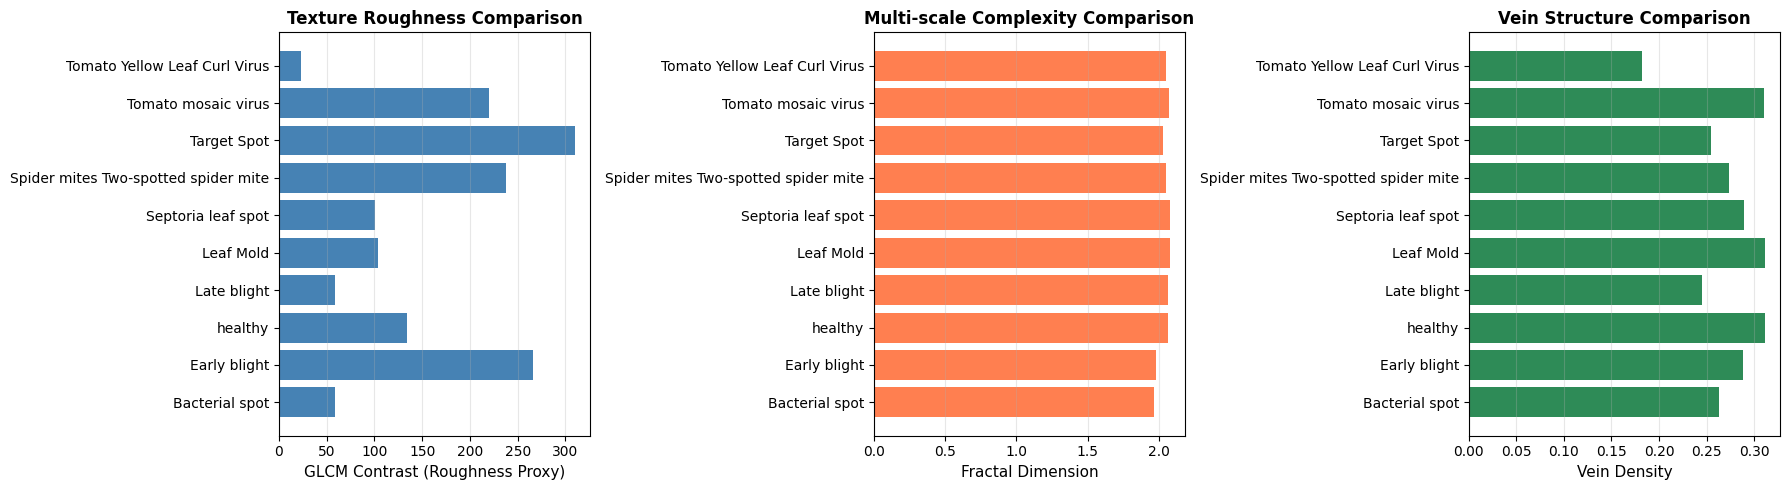


✓ Feature comparison complete!


In [9]:
# Extract features from one sample per class
print("Extracting features from sample images...\n")

class_features = {}

for class_dir in sorted(TRAIN_DIR.iterdir()):
    if class_dir.is_dir():
        image_files = list(class_dir.glob('*.jpg'))
        if image_files:
            sample_path = image_files[0]
            combined, _ = extract_all_features(sample_path)
            class_features[class_dir.name] = combined

# Compare GLCM contrast across classes
classes = list(class_features.keys())
glcm_contrasts = [class_features[c]['glcm'][0] for c in classes]  # First GLCM feature
fractal_dims = [class_features[c]['fractal'][0] for c in classes]
vein_densities = [class_features[c]['vein'][0] for c in classes]

# Simplify class names
simple_names = [c.replace('Tomato___', '').replace('_', ' ') for c in classes]

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(simple_names, glcm_contrasts, color='steelblue')
axes[0].set_xlabel('GLCM Contrast (Roughness Proxy)', fontsize=11)
axes[0].set_title('Texture Roughness Comparison', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(simple_names, fractal_dims, color='coral')
axes[1].set_xlabel('Fractal Dimension', fontsize=11)
axes[1].set_title('Multi-scale Complexity Comparison', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

axes[2].barh(simple_names, vein_densities, color='seagreen')
axes[2].set_xlabel('Vein Density', fontsize=11)
axes[2].set_title('Vein Structure Comparison', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'feature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature comparison complete!")

## 10. Summary

In [10]:
print("\n" + "="*80)
print("FEATURE EXTRACTION SUMMARY")
print("="*80)
print("\n✓ IMPLEMENTED FEATURES:")
print(f"   1. GLCM (60D): Contrast, correlation, energy, homogeneity, ASM")
print(f"   2. Fractal Dimension (1D): Box-counting method")
print(f"   3. Vein Geometry (10D): Density, branches, orientation, complexity")
print(f"   4. CNN (1280D): MobileNetV2 embeddings (PyTorch + CUDA)")
print(f"\n   Total: ~1351 dimensions per image")

print("\n✓ ENGINEERING INTERPRETATION:")
print("   • GLCM → Surface roughness and anisotropy (interpretable metrics)")
print("   • Fractal → Multi-scale complexity (single number summary)")
print("   • Vein → Directional structures (analogous to engineered grooves)")
print("   • CNN → High-level patterns (captures non-linear interactions)")

print("\n✓ HARDWARE UTILIZATION:")
print(f"   • Device: {device}")
if torch.cuda.is_available():
    print(f"   • GPU: {torch.cuda.get_device_name(0)}")
    print(f"   • CUDA: Enabled ✓")

print("\n✓ NEXT STEPS:")
print("   • Apply PCA for dimensionality reduction (1351D → 50D)")
print("   • Perform clustering (K-means, Hierarchical)")
print("   • Train CNN classifier for disease detection")
print("   • Visualize dual application framework")
print("="*80)

print("\n✓ Feature extraction notebook complete!")


FEATURE EXTRACTION SUMMARY

✓ IMPLEMENTED FEATURES:
   1. GLCM (60D): Contrast, correlation, energy, homogeneity, ASM
   2. Fractal Dimension (1D): Box-counting method
   3. Vein Geometry (10D): Density, branches, orientation, complexity
   4. CNN (1280D): MobileNetV2 embeddings (PyTorch + CUDA)

   Total: ~1351 dimensions per image

✓ ENGINEERING INTERPRETATION:
   • GLCM → Surface roughness and anisotropy (interpretable metrics)
   • Fractal → Multi-scale complexity (single number summary)
   • Vein → Directional structures (analogous to engineered grooves)
   • CNN → High-level patterns (captures non-linear interactions)

✓ HARDWARE UTILIZATION:
   • Device: cuda
   • GPU: NVIDIA GeForce RTX 3060 Laptop GPU
   • CUDA: Enabled ✓

✓ NEXT STEPS:
   • Apply PCA for dimensionality reduction (1351D → 50D)
   • Perform clustering (K-means, Hierarchical)
   • Train CNN classifier for disease detection
   • Visualize dual application framework

✓ Feature extraction notebook complete!
